In [53]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Mushroom classification

_Данные:_ <br>
https://www.kaggle.com/uciml/mushroom-classification/data

_Описание задачи:_<br>
Перед нами стоит задача классификации ядовитых грибов по категориальным признакам каждого конкретного экземпляра.

_Содержимое датасета:_ <br>

- **class:** edible=e, poisonous=p
- **cap-shape:** bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
- **cap-surface:** fibrous=f,grooves=g,scaly=y,smooth=s
- **cap-color:** brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
- **bruises:** bruises=t,no=f
- **odor:** almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
- **gill-attachment:** attached=a,descending=d,free=f,notched=n
- **gill-spacing:** close=c,crowded=w,distant=d
- **gill-size:** broad=b,narrow=n
- **gill-color:** black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
- **stalk-shape:** enlarging=e,tapering=t
- **stalk-root:** bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
- **stalk-surface-above-ring:** fibrous=f,scaly=y,silky=k,smooth=s
- **stalk-surface-below-ring:** fibrous=f,scaly=y,silky=k,smooth=s
- **stalk-color-above-ring:** brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- **stalk-color-below-ring:** brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- **veil-type:** partial=p,universal=u
- **veil-color:** brown=n,orange=o,white=w,yellow=y
- **ring-number:** none=n,one=o,two=t
- **ring-type:** cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
- **spore-print-color:** black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
- **population:** abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
- **habitat:** grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

Сразу стоит обратить внимание на то, что датасет полностью состоит из категориальных признаков, что, конечно же играет роль при выборе метода классификации.

In [39]:
mushrooms = pd.read_csv('mushrooms.csv')

Давайте посмотрим на данные: 

In [40]:
mushrooms.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surface-below-ring  \
0            c         n          k   ...                          s   
1            c         b          k   ...                          s   
2            c         b          n   ...                          s   
3            c         n          n   ...                          s   
4            w         b          k   ...                          s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [41]:
mushrooms.describe(include='all')

class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color   ...   stalk-surface-below-ring  \
count          8124      8124       8124   ...                       8124   
unique            2         2         12   ...                          4   
top               c         b          b   ...                          s   
freq           6812      5612       1728   ...                       4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top                         w                      w         p          w   
freq                     4464                   4384      8124       7924   

       ring-number ring-type spore-print-color population habitat  
count         8124      8124              8124       8124    8124  
unique           3         5                 9          6       7  
top              o         p                 w          v       d  
freq          7488      3968              2388       4040    3148  

[4 rows x 23 columns]

Посмотрим на столбцы, в которых единственное уникальное значение. Такие признаки можно сразу отбросить:

In [42]:
one_unique = list(map(lambda x: x[0], 
                      filter(lambda x: x[1]==1, [(col, len(mushrooms[col].unique())) for col in mushrooms.columns])))
mushrooms[one_unique].describe()
mushrooms.drop(one_unique, axis=1, inplace=True)

Проверим, есть ли в наших данных пропущенные значения, и выведем эти колонки:

In [43]:
[col for col in mushrooms.columns if mushrooms[col].hasnans]

[]

В наших руках оказались прекрасные данные, в которых нет пропусков. Такое случается очень редко

## Первичная обработка данных
Так как все признаки в нашем датасете - категориальные, можно сразу закодировать все колонки числами:

In [44]:
for column in mushrooms:
    mushrooms['n_' + column] = mushrooms[column].astype('category').cat.codes

In [45]:
mushrooms[['class', 'n_class']].head()

class  n_class
0     p        1
1     e        0
2     e        0
3     p        1
4     e        0

In [46]:
whole_df = mushrooms
mushrooms = mushrooms[[col for col in mushrooms if col.startswith('n_')]]

Построим матрицу корреляций для наших признаков:

In [47]:
corr = mushrooms.corr()
data = [go.Heatmap(z=corr.as_matrix(),
                   x=corr.columns.values,
                   y=corr.columns.values)]
layout = go.Layout(title='Features correlation matrix', height=600, width=700)
figure = go.Figure(data=data, layout=layout)
py.offline.iplot(figure)

Заметно, что многие столбцы коррелируют между собой с коэффициентом > 0.5 <br>
Нарисуем срез по пяти признакам, с наибольшей корреляцией с колонкой n_class

n_class          1.000000
n_gill-size      0.540024
n_population     0.298686
n_habitat        0.217179
n_cap-surface    0.178446
Name: n_class, dtype: float64


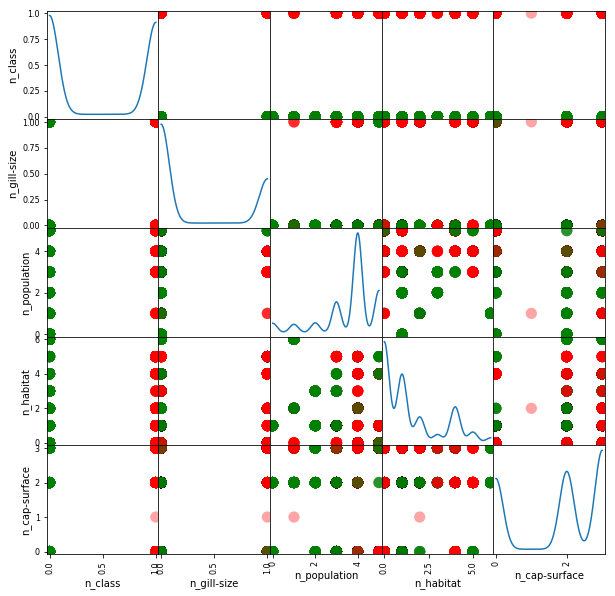

In [48]:
print(corr.n_class.sort_values(ascending=False)[:5])

color_wheel = {0: 'green', 
               1: 'red'}
colors = mushrooms['n_class'].map(lambda x: color_wheel.get(x))
scatter_matrix(mushrooms[corr.n_class.sort_values(ascending=False)[:5].index], 
               alpha=0.1, s=500, figsize=(10,10), diagonal='kde', color=colors)
pass

На данном графике мы можем увидеть, что наиболее сильно коррелирующие с колонкой n_class признаки, достаточно четко разделяют его на два класса.

Разделим наш датасет на обучающую и тестовую выборки в соотношении 70:30

In [51]:
X = mushrooms.drop('n_class', axis=1)
y = mushrooms['n_class']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

Для оценки качества нашей бинарной классификации будем использовать ROC кривую. Для её построения, напишем следующую функцию:

In [54]:
def plot_roc_curve(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)
    fig = py.tools.make_subplots(rows=1, cols=2, 
                                 subplot_titles=('Receiver operating characteristic: AUC={0:.3f})'.format(roc_auc),
                                                 'Precision-Recall: AUC={0:.3f}'.format(average_precision)), 
                                                 print_grid=False)
    fig.append_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy', mode='lines',
                                line=dict(color='darkorange'),
                                name='ROC curve'), 1, 1)
    fig.append_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', 
                                line=dict(color='navy', dash='dash'),
                                showlegend=False), 1, 1)
    fig.append_trace(go.Scatter(x=recall, y=precision, fill='tozeroy', mode='lines',
                                line=dict(color='navy'),
                                name='Precision-Recall curve'), 1, 2)

    fig.layout.update(height=400, title='Binary classification results')
    fig.layout.xaxis1.update(title='False Positive Rate', range=[0, 1])
    fig.layout.yaxis1.update(title='True Positive Rate', range=[0, 1.1])
    fig.layout.xaxis2.update(title='Recall', range=[0, 1])
    fig.layout.yaxis2.update(title='Precision', range=[0, 1.1])
    py.offline.iplot(fig)

Для визуализации процесса обучения будем строить график зависимости качества классификации от размера train-датасета

In [55]:
def plot_learning_curve(estimator, title, X, y, cv=None, ylim=(0,1.1), 
                        n_jobs=1, train_sizes=np.linspace(.01, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    data = [
        go.Scatter(x=train_sizes, y=train_scores_mean, name='Training score',
                   error_y=dict(type='data', symmetric=True, array=train_scores_std)),
        go.Scatter(x=train_sizes, y=test_scores_mean, name='Cross-validation score',
                   error_y=dict(type='data', symmetric=True, array=test_scores_std))
    ]
    layout = go.Layout(title=title, height=400, width=700, 
                       xaxis=dict(title='Training examples'), yaxis=dict(title='Score', range=ylim))
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig) 

## Классификация
### K-Nearest-Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [57]:
print(neigh.score(X_test, y_test)) 

0.995488105004


In [58]:
y_score = neigh.predict(X_test)
plot_roc_curve(y_test, y_score)

Практически идеальная классификация с первой попытки. <br>
Нарисуем, как ведет себя knn для различных размеров train выборки:

In [59]:
title = "Learning Curves (KNN, k=3)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X, y, cv=cv, ylim=(0.6, 1.1), n_jobs=4)

По графику выше, понятно, что качество классификации начинает снижаться только при достаточно сильном уменьшении обучающей выборки.
Посмотрим на зависимость ошибки от количества соседей:

In [60]:
neighbors = range(1, 30, 2)
err_train = []
err_test = []
mse = []

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(np.mean(model.predict(X_train) != y_train))
    err_test.append(np.mean(model.predict(X_test) != y_test))
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())
    
optimal_k = neighbors[mse.index(min(mse))]
print('Наименьшее значение ошибки {0:.4f} при k={1}'.format(min(mse), optimal_k))

data = [go.Scatter(y=err_train, name='Train error'), 
        go.Scatter(y=err_test, name='Test error'), 
        go.Scatter(y=mse, name='CV Mean squared error')]
layout = go.Layout(title='KNN results for different neighbors number', 
                   xaxis=dict(title='n neighbors'), 
                   yaxis=dict(title='error'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Наименьшее значение ошибки 0.0005 при k=1


Метод knn зависим от правильного выбора количества соседей. В нашем случае, лучшего результата классификации удается добиться при единственном соседе.

Также известно, что метод kNN очень чувствителен к выбору метрики расстояния между объектами. Давайте попробуем самые популярные и сравним ошибку классификации:

Идентификатор|args|distance function
---|---|---|---
“euclidean”|-|sqrt(sum((x - y)^2))
“manhattan”|-|sum( &#124; x - y &#124; )
“chebyshev”|-|max( &#124; x - y &#124; )
“minkowski”|p|sum( &#124; x - y &#124; ^p)^(1/p)

In [61]:
metrics = ['euclidean', 'manhattan',  'chebyshev', 'minkowski']
mse = []

for metric in metrics:
    model = KNeighborsClassifier(metric = metric)
    model.fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())


data = [go.Bar(x=metrics, y=mse, name='CV score')]
layout = go.Layout(title='kNN with different distance metrics', height=400, width=600, 
                   xaxis=dict(title='metrics'), 
                   yaxis=dict(title='MSE'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

В нашем случае с отличным результатом классификации победило Манхэттенское расстояние, что логически можно объяснить природой наших признаков. Все наши признаки - категориальные, так что разница в их суммах - хороший показатель близости.

Таким образом, мы сумели выяснить гиперпараметры для kNN, которые значительно улучшают классификацию:
Давайте применим их и посмотрим на результат классификации: 

In [62]:
neigh = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
neigh.fit(X_train, y_train)
print('Score {}'.format(neigh.score(X_test, y_test)))
y_score = neigh.predict(X_test)
plot_roc_curve(y_test, y_score)

Score 1.0


Правильно подобрав параметры, мы смогли улучшить нашу точность классификации до идеальной :)

### LogisticRegression

In [63]:
from sklearn import linear_model
regr = linear_model.LogisticRegression()
regr.fit(X_train, y_train)

print(regr.score(X_test, y_test)) 
y_score = regr.predict(X_test)
plot_roc_curve(y_test, y_score)

0.949138638228


Логистическая регрессия показала качество классификации заметно слабее kNN, рассмотренного выше.

Давайте посмотрим, как влияет на обучение размер датасета:

In [64]:
title = "Learning Curves (LogisticRegression, C=1.0)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.1), cv=cv, n_jobs=4)

Логистическая регрессия также очень устойчива к различному размеру датасета и проблемы начинаются только при малом размере выборки.

Попробуем сравнить результаты классификации для разных методов регуляризации:
- L1 $$\min_{w,s}\|w\|_1 + C\sum_{i=1}^{n}\log({\exp({-y_i(X^T_i w + C)})} + 1)$$
- L2 $$\min_{w,s}\frac{1}{2}w^{T}w + C\sum_{i=1}^{n}\log({\exp({-y_i(X^T_i w + C)})} + 1)$$

In [74]:
regs = ['l1', 'l2']

mse = []

for reg in regs:
    model = linear_model.LogisticRegression(penalty=reg)
    model.fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())


data = [go.Bar(x=regs, y=mse, name='CV score')]
layout = go.Layout(title='Logistic regression with different penalty', height=400, width=600, 
                   xaxis=dict(title='Regularization'), 
                   yaxis=dict(title='MSE'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Попробуем подобрать параметр C обратный силе регуляризации для логистической регрессии с $L1$ регуляризацией с помощью жадного поиска с кросс-валидацией по всему датасету

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 150, 200]}
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

gs = GridSearchCV(linear_model.LogisticRegression(penalty='l1'), cv=cv, param_grid=param_grid)

In [76]:
gs.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.3, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуем график cross-validation score в процессе подбора параметров

In [77]:
train_sizes = param_grid['C']
train_scores_mean = gs.cv_results_['mean_train_score']
train_scores_std = gs.cv_results_['std_train_score']
test_scores_mean = gs.cv_results_['mean_test_score']
test_scores_std = gs.cv_results_['std_test_score']

data = [
    go.Scatter(x=train_sizes, y=train_scores_mean, name='Train score mean',
               error_y=dict(type='data', symmetric=True, array=train_scores_std)),
    go.Scatter(x=train_sizes, y=test_scores_mean, name='Test score mean',
               error_y=dict(type='data', symmetric=True, array=test_scores_std))
]
layout = go.Layout(title='LogisticRegression(l1) score for different C parameter', 
                   height=400, width=700, xaxis=dict(title='C'), yaxis=dict(title='Score'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig) 

print(gs.best_params_)

{'C': 200}


Лучшего значения классификации удалось добиться при $C=200$, что означает - ослабление регуляризации положительно влияет на качество классификации в нашем случае

Попробуем использовать различные солверы, чтобы оценить их воздействие на результат классификации

In [79]:
solvers = ['liblinear', 'saga']

mse = []

for solver in solvers:
    model = linear_model.LogisticRegression(penalty='l1', solver=solver)
    model.fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())


data = [go.Bar(x=solvers, y=mse, name='CV score')]
layout = go.Layout(title='Logistic regression with different solvers', height=400, width=600, 
                   xaxis=dict(title='metrics'), 
                   yaxis=dict(title='MSE'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Как можно заметить, для liblinear солвера значение ошибки незначительно меньше. Это объясняется тем, что saga используется для больших датасетов, а на нашем он даже не сошелся.

In [80]:
print(gs.best_estimator_.score(X_test, y_test)) 
y_score = gs.best_estimator_.predict(X_test)
plot_roc_curve(y_test, y_score)

0.971698113208


Верно подобрав параметр С и регуляризацию мы смогли заметно улучшить результат классификации

### Linear Discriminant Analysis

In [81]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [82]:
print(lda.score(X_test, y_test)) 
y_score = lda.predict(X_test)
plot_roc_curve(y_test, y_score)

0.947908121411


Как видно из ROC-кривой, LDA без подбора параметров показывает результат не самой успешной классификации на нашем датасете. 
На самом деле, использование в нашей задаче LDA не совсем корректно, так как метод подразумевает, что все признаки - непрерывные величины и объекты и распределены по нормальному закону.

Попробуем посмотреть, как на LDA влияет размер выборки:

In [83]:
title = "Learning Curves (LinearDiscriminantAnalysis, solver='svd')"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LinearDiscriminantAnalysis()
plot_learning_curve(estimator, title, X, y, ylim=(0.8, 1.1), cv=cv, n_jobs=4)

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Тестовая и трейн learning curve сходятся уже на достаточно маленькой выборке

Посмотрим, какие результаты  показывает LDA при использовании разных солверов:

In [85]:
solvers = ['svd', 'lsqr', 'eigen']

mse = []

for solver in solvers:
    model = LinearDiscriminantAnalysis(solver=solver)
    model.fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())


data = [go.Bar(x=solvers, y=mse, name='CV score')]
layout = go.Layout(title='LDA with different solvers', height=400, width=600, 
                   xaxis=dict(title='metrics'), 
                   yaxis=dict(title='MSE'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Singular value decomposition и Least squares solution показали одинаково хорошие результаты, однако svd не вычисляет матрицу ковариаций, что делает его легче для вычисления на больших датасетах

Попробуем ослабить условия и применить QDA:

### Quadratic Discriminant Analysis (QDA)

In [86]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [87]:
print(qda.score(X_test, y_test)) 
y_score = qda.predict(X_test)
plot_roc_curve(y_test, y_score)

0.993437243642


In [88]:
title = "Learning Curves (QuadraticDiscriminantAnalysis, reg_param=0.0)"

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

estimator = QuadraticDiscriminantAnalysis()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.1), cv=cv, n_jobs=4)

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning:

Variables are collinear

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning:

Variables are collinear

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning:

Variables are collinear



In [100]:
regs = np.linspace(1e-6, 1.0, 100)

mse = []

for reg in regs:
    model = QuadraticDiscriminantAnalysis(reg_param=reg)
    model.fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    mse.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=3).mean())


data = [go.Bar(x=regs, y=mse, name='CV score')]
layout = go.Layout(title='QDA with different reg_param', height=400, width=600, 
                   xaxis=dict(title='Regularization'), 
                   yaxis=dict(title='MSE'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

Как можно заметить, для малого значения параметра регуляризации - самое низкое значение ошибки

In [104]:
qda = QuadraticDiscriminantAnalysis(reg_param=1e-6)
qda.fit(X_train, y_train)
print(qda.score(X_test, y_test)) 
y_score = qda.predict(X_test)
plot_roc_curve(y_test, y_score)

0.993437243642


Как можно заметить, от подстановки значения регуляризации, точность классификации практически не изменилась

### Naive Bayes

In [91]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [92]:
print(gnb.score(X_test, y_test)) 
y_score = gnb.predict(X_test)
plot_roc_curve(y_test, y_score)

0.929450369155


Наивный Байесовский классификатор на данных с только категориальными признаками работает сравнительно плохо 

Попробуем исследовать зависимость точности классификации от размера выборки:

In [93]:
title = "Learning Curves (GaussianNB)"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.1), cv=cv, n_jobs=4)

Для выборок малых размеров NB очень неустойчив

### Support vector machine (SVM)

In [94]:
from sklearn import svm

svmclf = svm.SVC()
svmclf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
print(svmclf.score(X_test, y_test)) 
y_score = svmclf.predict(X_test)
plot_roc_curve(y_test, y_score)

1.0


Метод SVM, строящий предположение о линейной разделимости классов показал самый лучший результат без подбора параметров.
Посмотрим на зависимость его результатов от размеров выборки

In [96]:
title = "Learning Curves (SVM, C=1.0, kernel='rbf')"

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

estimator = svm.SVC()
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.1), cv=cv, n_jobs=4)

Как можно увидеть, SVM также устойчив начиная с выборки размером в 1500 объектов

Проследим влияние параметров $С$ и $\gamma$

In [97]:
Cs = np.linspace(0.1, 100, 3)
Gammas = np.linspace(1e-4, 1, 5)
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
gs = GridSearchCV(svm.SVC(kernel='rbf'), dict(C=Cs, gamma=Gammas), cv=cv)

gs.fit(X, y)

scores = [x[1] for x in gs.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

data = []
for ind, i in enumerate(Cs):
    data.append(go.Scatter(x=Gammas, y=scores[ind], name='C={}'.format(i)))
layout = go.Layout(title='SVM scores for different C and gamma', 
                   xaxis=dict(title='Gamma'), 
                   yaxis=dict(title='Score'))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:747: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



Проведя это небольшое исследование можно отметить, что для классификации объектов с исключительно категориальными признаками, методы, делающие предположение о распределении признаков/объектов, уступают knn или SVM.